### This notebook is trying to implement and backtest a pair trading strategy using Air Liquid and Linde Stocks

# 📘 PLAN DE NOTEBOOK — PAIR TRADING (PROPRE)

Pair étudié :
- **BNP Paribas**
- **Société Générale**

---

## 🟦 ÉTAPE 0 — Données (base propre)
**Objectif :** partir sur quelque chose de sain

- Télécharger les **prix de clôture**
- Même fréquence (daily)
- Même calendrier (dates alignées)
- Période : **1 an minimum**

👉 Output :  
`date | price_A | price_B`

---

## 🟦 ÉTAPE 1 — Visualisation brute
**Objectif :** comprendre les ordres de grandeur

- Plot :
  - Prix BNP
  - Prix SG

👉 Observation attendue :
- échelles différentes
- tendance globale similaire

---

## 🟦 ÉTAPE 2 — Prix normalisés
**Objectif :** comparer les trajectoires

- Normaliser chaque prix par son prix initial
- Plot :
  - Air Liquide normalisé
  - Linde normalisé

👉 Ce que tu regardes :
- divergences / convergences
- proximité de long terme

⚠️ Purement visuel, **pas de signal ici**

---

## 🟦 ÉTAPE 3 — Returns & corrélation (diagnostic)
**Objectif :** vérifier la cohérence du pair

- Calculer les returns (%)
- Plot :
  - returns A
  - returns B
- Calculer :
  - corrélation globale
  - corrélation glissante (ex : 60 jours)

👉 Corrélation faible → **STOP**

---

## 🟦 ÉTAPE 4 — Calcul du β (hedge ratio)
**Objectif :** équilibrer correctement le pair

- Régression linéaire :
  - `A = α + β × B`
- Fenêtre : 6 mois ou 1 an

👉 À récupérer :
- β (clé)
- α (secondaire)

---

## 🟦 ÉTAPE 5 — Construction du spread
**Objectif :** créer l’objet tradable

- Spread : Spread_t = A_t − β · B_t

- Plot du spread

👉 À vérifier :
- oscillations autour d’une moyenne
- absence de dérive

---

## 🟦 ÉTAPE 6 — Z-score du spread
**Objectif :** créer le signal de trading

- Moyenne et écart-type du spread
- Fenêtre glissante (ex : 60 jours)
- Z-score : Z_t = (Spread_t − μ) / σ


- Plot :
- Z-score
- lignes +2 / 0 / −2

👉 **Signal de trading**

---

## 🟦 ÉTAPE 7 — Règles de trading
**Objectif :** aucune ambiguïté

- **Entrée**
- Z > +2 → short A / long B
- Z < −2 → long A / short B

- **Sortie**
- |Z| < 0.5
- ou timeout (ex : 20 jours)

- **Stop**
- |Z| > 3
- ou perte max par trade

---

## 🟦 ÉTAPE 8 — Backtest
**Objectif :** mesurer la performance réelle

À calculer :
- PnL par trade
- PnL cumulé
- Sharpe ratio
- Max drawdown
- Win rate
- Durée moyenne des trades

⚠️ Inclure :
- coûts de transaction
- slippage (même approximatif)

---

## 🟦 ÉTAPE 9 — Tests de robustesse
**Objectif :** éviter le faux alpha

- Varier :
- fenêtre β (3m / 6m / 1y)
- fenêtre Z-score (30 / 60 / 90)
- seuils (1.5 / 2 / 2.5)

- Out-of-sample :
- calibration sur 6 mois
- test sur 6 mois

---

## 🟦 ÉTAPE 10 — Conclusion
**Objectif :** être honnête sur la stratégie

- Mean reversion réelle ?
- Performance stable ?
- Drawdown acceptable ?
- Cassures structurelles ?

---

## 🧠 Résumé ultra-court

1. Prix  
2. Prix normalisés  
3. Returns & corrélation  
4. β  
5. Spread  
6. Z-score  
7. Règles  
8. Backtest  
9. Robustesse  



## Partie 0

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
SYMBOL_A = "BNP.PA"   # Air Liquide
SYMBOL_B = "GLE.PA"     # Linde
PERIOD = "2y"

# Téléchargement des données
data = yf.download(
    [SYMBOL_A, SYMBOL_B],
    period=PERIOD,
    auto_adjust=False,
    progress=False
)

# On ne garde que les prix ajustés
prices = data["Adj Close"].copy()

# Renommage clair des colonnes
prices.columns = ["BNP", "SG"]

# Nettoyage
prices = prices.dropna()

# Vérification rapide
print(prices.head())
print(prices.tail())
print(prices.isna().sum())


                  BNP         SG
Date                            
2024-01-08  53.751041  23.067106
2024-01-09  53.316883  23.127844
2024-01-10  53.146622  22.824146
2024-01-11  51.759003  21.992479
2024-01-12  51.784542  21.903706
                  BNP         SG
Date                            
2025-12-31  80.790001  68.720001
2026-01-02  81.919998  70.080002
2026-01-05  81.870003  70.320000
2026-01-06  80.570000  69.860001
2026-01-07  79.900002  69.879997
BNP    0
SG     0
dtype: int64


In [19]:
prices.columns

Index(['BNP', 'SG'], dtype='object')

## Partie 1

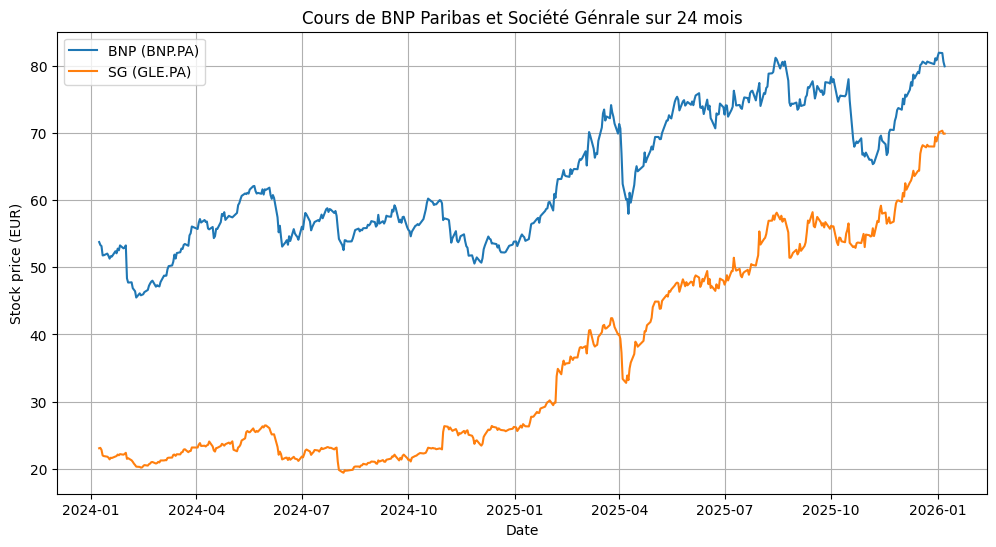

In [20]:
plt.figure(figsize=(12, 6))

plt.plot(prices['BNP'], label='BNP (BNP.PA)')
plt.plot(prices['SG'], label='SG (GLE.PA)')

plt.title("Cours de BNP Paribas et Société Génrale sur 24 mois")
plt.xlabel("Date")
plt.ylabel("Stock price (EUR)")
plt.legend()
plt.grid(True)
plt.show()

## Partie 2

Rappel :  prix normalisé (t) = prix (t) / prix(0)

In [21]:
norm_prices = prices.copy()


norm_prices["BNP"]  = prices["BNP"] / prices["BNP"].iloc[0]
norm_prices["SG"]  = prices["SG"] / prices["SG"].iloc[0]

norm_prices

,BNP,SG
Date,,
2024-01-08,1.000000,1.000000
2024-01-09,0.991923,1.002633
2024-01-10,0.988755,0.989467
2024-01-11,0.962940,0.953413
2024-01-12,0.963415,0.949565
...,...,...
2025-12-31,1.503041,2.979134
2026-01-02,1.524063,3.038092
2026-01-05,1.523133,3.048497


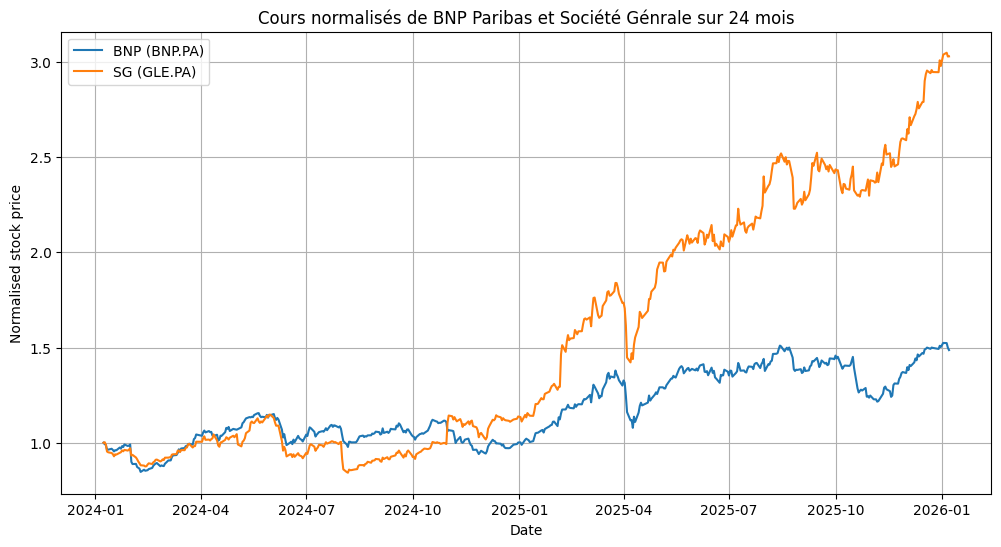

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(norm_prices['BNP'], label='BNP (BNP.PA)')
plt.plot(norm_prices['SG'], label='SG (GLE.PA)')

plt.title("Cours normalisés de BNP Paribas et Société Génrale sur 24 mois")
plt.xlabel("Date")
plt.ylabel("Normalised stock price")
plt.legend()
plt.grid(True)
plt.show()

## Partie 3
### 3.1 Returns


r_t = (P_t - P_{t-1}) / P_{t-1}



In [24]:
returns = prices.pct_change()

returns 


,BNP,SG
Date,,
2024-01-08,NaN,NaN
2024-01-09,-0.008077,0.002633
2024-01-10,-0.003193,-0.013131
2024-01-11,-0.026109,-0.036438
2024-01-12,0.000493,-0.004037
...,...,...
2025-12-31,-0.003822,-0.009798
2026-01-02,0.013987,0.019790
2026-01-05,-0.000610,0.003425


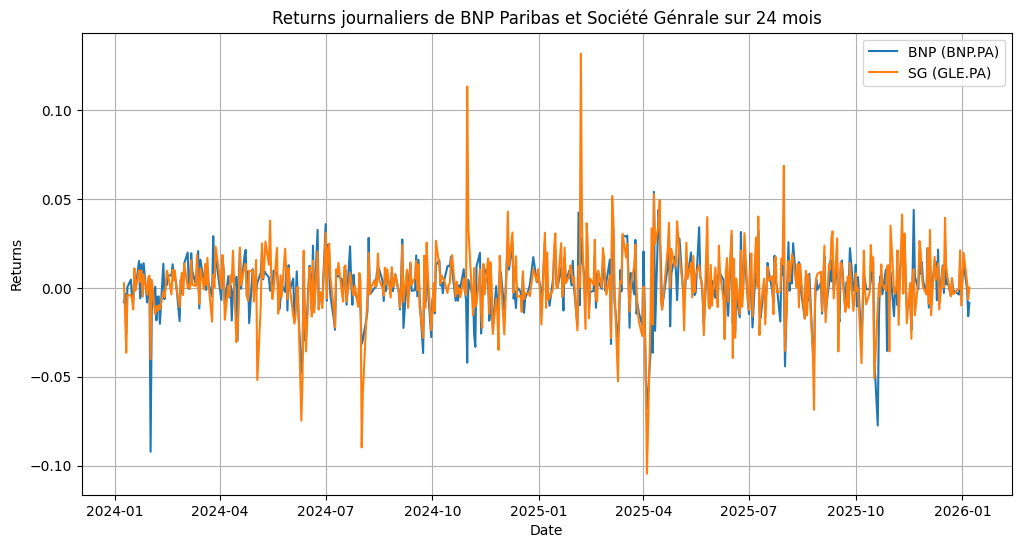

In [25]:
plt.figure(figsize=(12, 6))

plt.plot(returns['BNP'], label='BNP (BNP.PA)')
plt.plot(returns['SG'], label='SG (GLE.PA)')

plt.title("Returns journaliers de BNP Paribas et Société Génrale sur 24 mois")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.show()

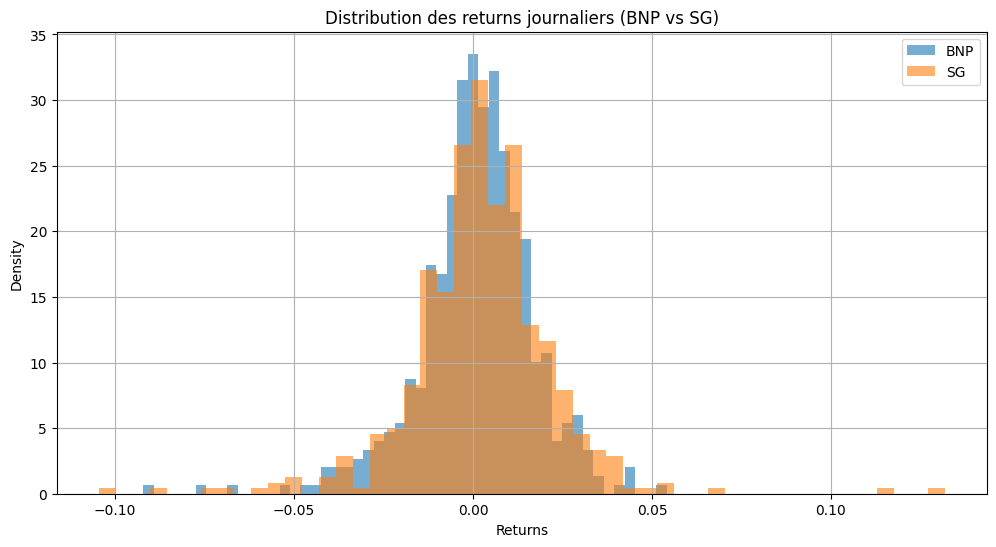

In [26]:
plt.figure(figsize=(12, 6))

plt.hist(returns["BNP"], bins=50, alpha=0.6, label="BNP", density=True)
plt.hist(returns["SG"],  bins=50, alpha=0.6, label="SG",  density=True)

plt.title("Distribution des returns journaliers (BNP vs SG)")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


### 3.2 Correlation et correl glissante

In [39]:
norm_prices[['BNP', 'SG']].corr(method='pearson')

,BNP,SG
BNP,1.000000,0.930658
SG,0.930658,1.000000


In [36]:
# Correlation 2 ans
norm_prices.loc[norm_prices.index >= norm_prices.index.max() - pd.DateOffset(years=2), ['BNP', 'SG']].corr().iloc[0,1]

np.float64(0.9306581503321258)

In [37]:
# Correlation 1 ans
norm_prices.loc[norm_prices.index >= norm_prices.index.max() - pd.DateOffset(years=1), ['BNP', 'SG']].corr().iloc[0,1]

np.float64(0.845690548780027)

In [ ]:
# Correlation 6 mois
norm_prices.loc[norm_prices.index >= norm_prices.index.max() - pd.DateOffset(months=6), ['BNP', 'SG']].corr().iloc[0,1]

np.float64(0.4526724245060644)

In [41]:
rolling_corr = norm_prices["BNP"].rolling(window=60, min_periods=10).corr(norm_prices["SG"])
rolling_corr

Date
2024-01-08         NaN
2024-01-09         NaN
2024-01-10         NaN
2024-01-11         NaN
2024-01-12         NaN
                ...   
2025-12-31    0.778656
2026-01-02    0.805007
2026-01-05    0.827207
2026-01-06    0.846855
2026-01-07    0.866188
Length: 511, dtype: float64

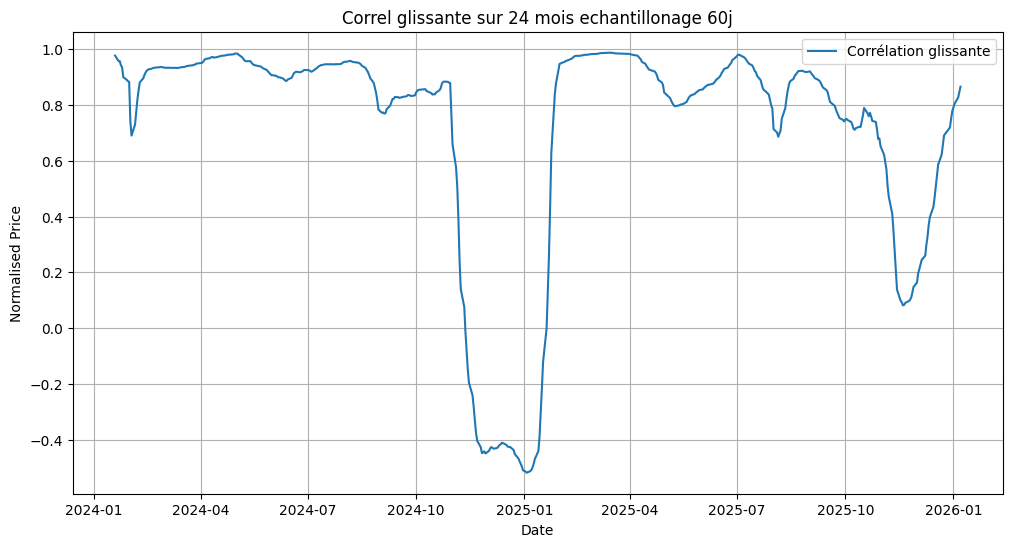

In [42]:
plt.figure(figsize=(12, 6))

plt.plot(rolling_corr, label='Corrélation glissante')


plt.title("Correl glissante sur 24 mois echantillonage 60j")
plt.xlabel("Date")
plt.ylabel("Normalised Price")
plt.legend()
plt.grid(True)
plt.show()

## Partie 4 Calcul du Beta

commentaires : 

❌ Ce qu’on ne fait PAS encore

pas de β glissant

pas de log-prices

pas de co-intégration

pas de Kalman filter

On reste simple et juste.

In [44]:
%pip install statsmodels

  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 3.5 MB/s  0:00:02eta 0:00:01
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [45]:
import statsmodels.api as sm

X = prices["SG"]
Y = prices["BNP"]

X = sm.add_constant(X)   # ajoute α
model = sm.OLS(Y, X).fit()

beta = model.params["SG"]
beta


np.float64(0.6101713887576685)

## Construction du spread 

In [46]:
spread = prices.copy()

spread = prices['BNP'] - prices["SG"] * beta

spread 

Date
2024-01-08    39.676153
2024-01-09    39.204934
2024-01-10    39.219981
2024-01-11    38.339821
2024-01-12    38.419528
                ...    
2025-12-31    38.859022
2026-01-02    39.159186
2026-01-05    38.962751
2026-01-06    37.943426
2026-01-07    37.261227
Length: 511, dtype: float64

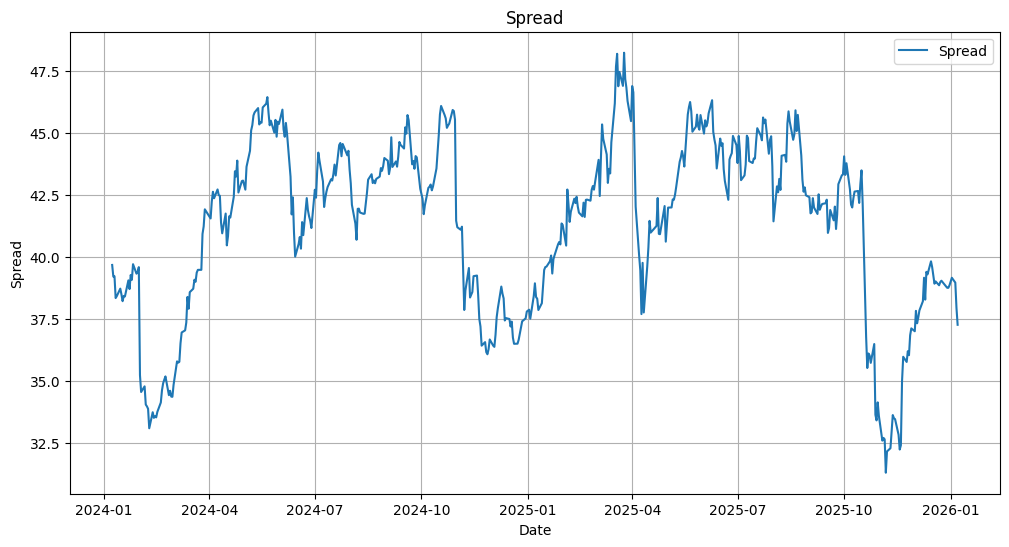

In [47]:
plt.figure(figsize=(12, 6))

plt.plot(spread, label='Spread')


plt.title("Spread")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()

## Calcul du Z-score

In [49]:
window = 60

spread_mean = spread.rolling(window).mean()
spread_std  = spread.rolling(window).std()

z_score = (spread - spread_mean) / spread_std

z_score

Date
2024-01-08         NaN
2024-01-09         NaN
2024-01-10         NaN
2024-01-11         NaN
2024-01-12         NaN
                ...   
2025-12-31    0.543710
2026-01-02    0.659696
2026-01-05    0.625677
2026-01-06    0.339444
2026-01-07    0.155000
Length: 511, dtype: float64

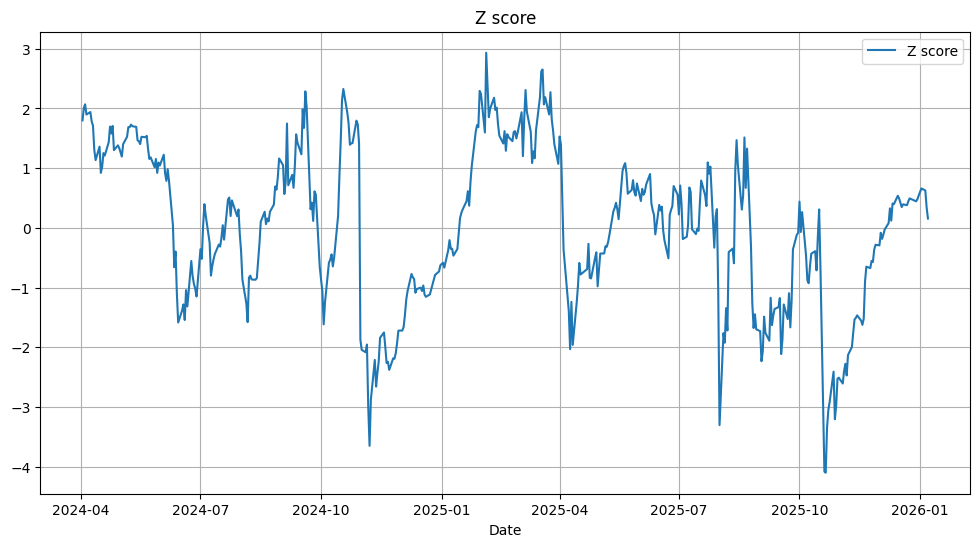

In [50]:
plt.figure(figsize=(12, 6))

plt.plot(z_score, label='Z score')


plt.title("Z score")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
import numpy as np
import pandas as pd

# --- Inputs you already have ---
# prices: DataFrame indexed by Date with columns ["BNP","SG"] (prices or adj prices)
# beta: float (from OLS on prices)
# spread: Series (BNP - beta*SG)  [we'll recompute for safety]
# z_score: Series (computed from spread with rolling mean/std)

# --- Parameters (edit if you want) ---
ENTRY_Z = 2.0
EXIT_Z = 0.5
STOP_Z = 3.0          # set to None if you don't want a stop on z-score
MAX_HOLD_DAYS = 20    # set to None if you don't want a time stop
CAPITAL = 1.0         # normalized capital (PnL in "capital units")
COST_BPS = 0.0        # transaction cost per trade leg, in bps of notional (e.g., 2 = 2 bps)

# --- Build spread & z-score if not already done (safe) ---
spread = prices["BNP"] - beta * prices["SG"]

window = 60
mu = spread.rolling(window).mean()
sd = spread.rolling(window).std()
z = (spread - mu) / sd

# Daily returns (for PnL)
rets = prices.pct_change()

# --- Backtest state ---
pos = pd.Series(0, index=prices.index, dtype=int)  # +1: long spread, -1: short spread, 0: flat
hold_days = 0

# Portfolio weights when in position:
# long spread  => long BNP, short beta*SG  (weights +1, -beta)
# short spread => short BNP, long beta*SG  (weights -1, +beta)
w_bnp = pd.Series(0.0, index=prices.index)
w_sg  = pd.Series(0.0, index=prices.index)

# --- Generate positions day by day ---
for i in range(1, len(prices.index)):
    t = prices.index[i]
    zt = z.iloc[i]

    # If z is NaN (warm-up period), stay flat
    if np.isnan(zt):
        pos.iloc[i] = 0
        hold_days = 0
        continue

    prev_pos = pos.iloc[i-1]

    # Default: carry previous position
    pos.iloc[i] = prev_pos
    if prev_pos != 0:
        hold_days += 1
    else:
        hold_days = 0

    # --- Exit rules ---
    if prev_pos != 0:
        exit_signal = (abs(zt) < EXIT_Z)
        time_exit = (MAX_HOLD_DAYS is not None and hold_days >= MAX_HOLD_DAYS)
        stop_signal = (STOP_Z is not None and abs(zt) > STOP_Z)

        if exit_signal or time_exit or stop_signal:
            pos.iloc[i] = 0
            hold_days = 0

    # --- Entry rules (only if flat) ---
    if pos.iloc[i] == 0:
        if zt > ENTRY_Z:
            # spread high => short spread: short BNP, long beta*SG
            pos.iloc[i] = -1
            hold_days = 1
        elif zt < -ENTRY_Z:
            # spread low => long spread: long BNP, short beta*SG
            pos.iloc[i] = +1
            hold_days = 1

# --- Convert positions to weights (notional-neutral-ish) ---
w_bnp[pos == +1] = +1.0
w_sg[pos == +1]  = -beta

w_bnp[pos == -1] = -1.0
w_sg[pos == -1]  = +beta

# Shift weights by 1 day to avoid lookahead (trade at close -> hold next day)
w_bnp = w_bnp.shift(1).fillna(0.0)
w_sg  = w_sg.shift(1).fillna(0.0)

# --- Portfolio daily return (simple) ---
port_ret = w_bnp * rets["BNP"] + w_sg * rets["SG"]
port_ret = port_ret.fillna(0.0)

# --- Transaction costs (very simple model) ---
# cost applied when weights change (enter/exit/flip). COST_BPS per leg on notional change.
if COST_BPS and COST_BPS > 0:
    dw_bnp = w_bnp.diff().abs().fillna(0.0)
    dw_sg  = w_sg.diff().abs().fillna(0.0)
    cost = (COST_BPS / 1e4) * (dw_bnp + dw_sg)  # bps -> fraction
    port_ret = port_ret - cost

# --- Equity curve ---
equity = (1 + port_ret).cumprod() * CAPITAL

# --- Basic stats ---
def sharpe(x, periods=252):
    x = x.dropna()
    if x.std(ddof=0) == 0:
        return np.nan
    return np.sqrt(periods) * x.mean() / x.std(ddof=0)

roll_max = equity.cummax()
drawdown = equity / roll_max - 1.0

stats = {
    "Total Return": equity.iloc[-1] / equity.iloc[0] - 1.0,
    "Sharpe (daily)": sharpe(port_ret),
    "Max Drawdown": drawdown.min(),
    "Avg Daily Ret": port_ret.mean(),
    "Vol Daily": port_ret.std(ddof=0),
    "Days Invested": int((pos.shift(1).fillna(0) != 0).sum()),
    "Num Trades (approx)": int((pos.diff().fillna(0) != 0).sum() / 2),  # rough
}

results = pd.DataFrame({
    "equity": equity,
    "port_ret": port_ret,
    "position": pos,
    "z": z,
    "spread": spread
})

print(stats)
# results is your full backtest table


{'Total Return': np.float64(0.1933335541569674), 'Sharpe (daily)': np.float64(0.7087222985047053), 'Max Drawdown': np.float64(-0.08974580866986193), 'Avg Daily Ret': np.float64(0.000381651428865379), 'Vol Daily': np.float64(0.00854852263365223), 'Days Invested': 149, 'Num Trades (approx)': 9}


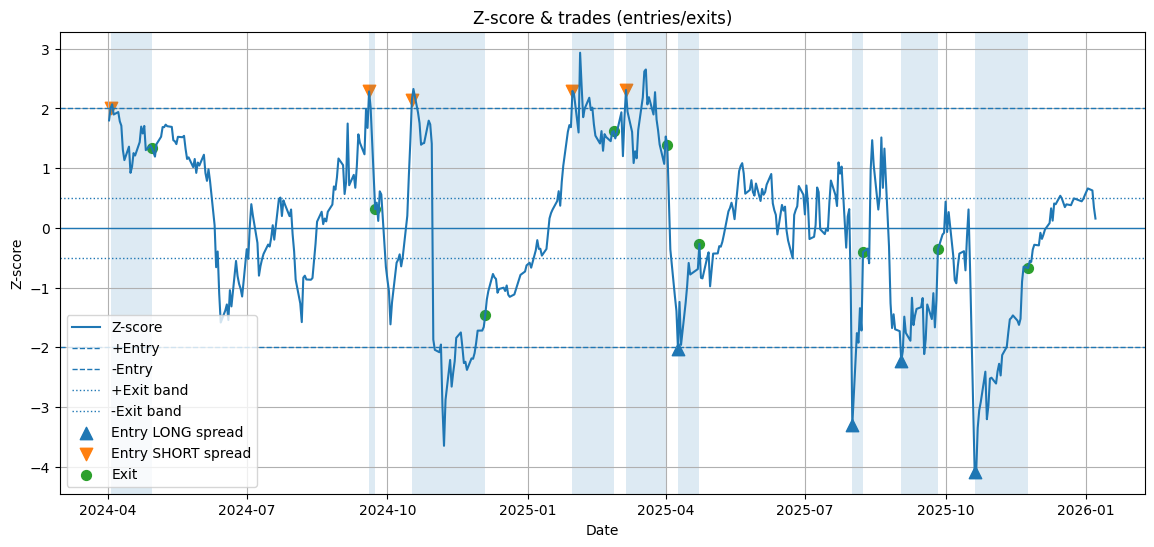

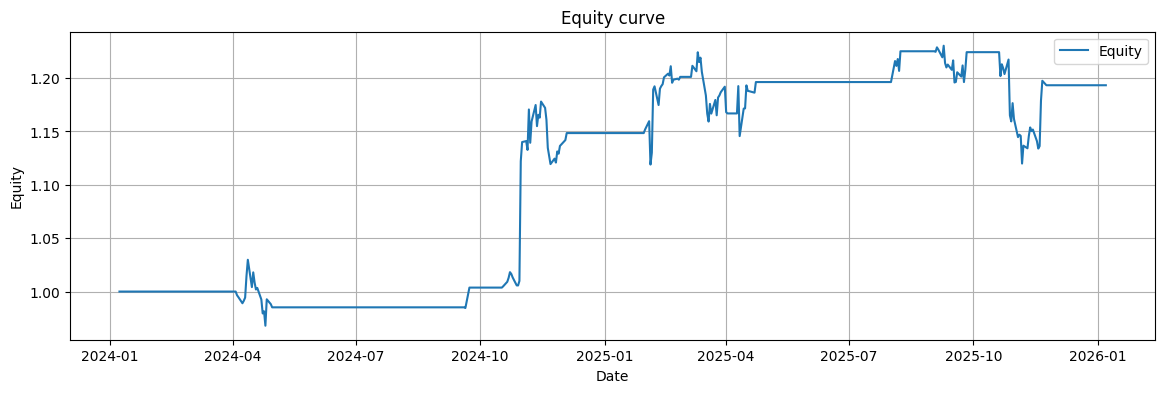

In [52]:
import numpy as np
import matplotlib.pyplot as plt

ENTRY_Z = 2.0
EXIT_Z = 0.5
STOP_Z = 3.0  # si tu l'utilises

z = results["z"]
pos = results["position"]
equity = results["equity"]

# Détecter événements
pos_prev = pos.shift(1).fillna(0)

entry_long  = (pos_prev == 0) & (pos == 1)
entry_short = (pos_prev == 0) & (pos == -1)
exit_trade  = (pos_prev != 0) & (pos == 0)

# --- Figure Z-score + trades ---
plt.figure(figsize=(14, 6))
plt.plot(z.index, z, label="Z-score")

# Seuils
plt.axhline(ENTRY_Z, linestyle="--", linewidth=1, label="+Entry")
plt.axhline(-ENTRY_Z, linestyle="--", linewidth=1, label="-Entry")
plt.axhline(EXIT_Z, linestyle=":", linewidth=1, label="+Exit band")
plt.axhline(-EXIT_Z, linestyle=":", linewidth=1, label="-Exit band")
plt.axhline(0, linewidth=1)

# Marqueurs
plt.scatter(z.index[entry_long],  z[entry_long],  marker="^", s=80, label="Entry LONG spread")
plt.scatter(z.index[entry_short], z[entry_short], marker="v", s=80, label="Entry SHORT spread")
plt.scatter(z.index[exit_trade],  z[exit_trade],  marker="o", s=50, label="Exit")

# Shading des périodes en position
in_trade = (pos != 0).astype(int)
starts = (in_trade.diff() == 1).fillna(False)
ends   = (in_trade.diff() == -1).fillna(False)

start_dates = list(z.index[starts])
end_dates   = list(z.index[ends])

# si on finit en position, on ferme à la dernière date pour l'affichage
if in_trade.iloc[-1] == 1:
    end_dates.append(z.index[-1])

for s, e in zip(start_dates, end_dates):
    plt.axvspan(s, e, alpha=0.15)

plt.title("Z-score & trades (entries/exits)")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.grid(True)
plt.legend()
plt.show()

# --- (Optionnel) Equity curve ---
plt.figure(figsize=(14, 4))
plt.plot(equity.index, equity, label="Equity")
plt.title("Equity curve")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.legend()
plt.show()
